In [33]:
from __future__ import print_function

import pandas as pd 
import numpy as np 
import sklearn

# NLTK/NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk import FreqDist, word_tokenize
import string, re
import urllib
from nltk.corpus import stopwords
from gensim.models import word2vec
from nltk.collocations import *
import gensim
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


# Classifiers 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier  

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import scikitplot as skplt

#Sampling
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

#Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# miscellaneous
from sklearn.utils import resample
import sklearn.decomposition as decomposition

import warnings 
warnings.filterwarnings("ignore")

import csv
import pickle

%run my_functions.ipynb

In [34]:
with open('data/cleaned-reshuffled.pkl', 'rb') as f:
	df = pickle.load(f)

In [35]:
df.head()

,id,label,tweet,tidy_tweet,no_hash_tweet,tokenized_tweet,stemmed_tokens,lemmatized_tokens,lem_tweet,stem_tweet
0,29727,0,sad to see the scenes of hooligans pre #engrus...,sad to see the scenes of hooligans pre #engrus...,sad to see the scenes of hooligans pre engrus ...,"[sad, to, see, the, scenes, of, hooligans, pre...","[sad, to, see, the, scene, of, hooligan, pre, ...","[sad, to, see, the, scene, of, hooligan, pre, ...",sad to see the scenes of hooligans pre engrus ...,sad to see the scenes of hooligans pre engrus ...
1,14466,0,#gooddyeyoung #yoyoyo !! super happy to be ap...,#gooddyeyoung #yoyoyo super happy to be apa of...,gooddyeyoung yoyoyo super happy to be apa of t...,"[gooddyeyoung, yoyoyo, super, happy, to, be, a...","[gooddyeyoung, yoyoyo, super, happi, to, be, a...","[gooddyeyoung, yoyoyo, super, happy, to, be, a...",gooddyeyoung yoyoyo super happy to be apa of t...,gooddyeyoung yoyoyo super happy to be apa of t...
2,18194,0,queen evil's bihdayð#lnic #lnicjustanevilbd...,queen evil s bihday #lnic #lnicjustanevilbday ...,queen evil s bihday lnic lnicjustanevilbday bi...,"[queen, evil, s, bihday, lnic, lnicjustanevilb...","[queen, evil, s, bihday, lnic, lnicjustanevilb...","[queen, evil, s, bihday, lnic, lnicjustanevilb...",queen evil s bihday lnic lnicjustanevilbday bi...,queen evil s bihday lnic lnicjustanevilbday bi...
3,18283,1,@user you might be a libtard if... #libtard #...,you might be a libtard if #libtard #sjw #liber...,you might be a libtard if libtard sjw liberal ...,"[you, might, be, a, libtard, if, libtard, sjw,...","[you, might, be, a, libtard, if, libtard, sjw,...","[you, might, be, a, libtard, if, libtard, sjw,...",you might be a libtard if libtard sjw liberal ...,you might be a libtard if libtard sjw liberal ...
4,25845,0,what are your goals? find out here... #smile...,what are your goals find out here #smile,what are your goals find out here smile,"[what, are, your, goals, find, out, here, smile]","[what, are, your, goal, find, out, here, smile]","[what, are, your, goal, find, out, here, smile]",what are your goals find out here smile,what are your goals find out here smil


## Train / Val / Test Split

In [36]:
X = df.drop(['label'], axis = 1)

In [37]:
y = df['label']

In [38]:
#splitting into train and test 
X_model, X_test, y_model, y_test = train_test_split(X, y, stratify = y, test_size=0.20, random_state=123)

In [39]:
#splitting "model" into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, stratify = y_model, test_size=0.20, random_state=123)

## Comparing Vectorization and Method Performance

In [40]:
#initializing vectorizers and creating tuple for wrapper comparison function

count_vect = CountVectorizer(min_df = .001, stop_words='english')
count_ngram1_2 = CountVectorizer(min_df = .001, stop_words='english')
count_ngram1_3 = CountVectorizer(min_df = .001, stop_words='english')

tfidf_vect = TfidfVectorizer(min_df=.001, stop_words ='english')
tfidf_ngram1_2 = TfidfVectorizer(ngram_range=(1,2), min_df=.001, stop_words ='english')
tfidf_ngram1_3 = TfidfVectorizer(ngram_range=(2,3), min_df=.001, stop_words ='english')

vectorization_list = [('COUNT_VECTORIZER', count_vect),
                      ('COUNT_NGRAM_1_2', count_ngram1_2),
                      ('COUNT_NGRAM_1_3', count_ngram1_3),
                      ('TFIDF_VECTORIZER', tfidf_vect),
                      ('TFIDF_NGRAM_1_2', tfidf_ngram1_2),
                      ('TFIDF_NGRAM_1_3', tfidf_ngram1_3)]

# Multinomial Naive Bayes (MNB)

#### Initial Comparision: Multiple Vectorizer and Class Balance Corrections

In [24]:
np.random.seed(0)

In [25]:
#MNB with no class balance corrections
nb_results1 = compare_vectorization_model(X_train.lem_tweet, y_train, 
                                   X_val.lem_tweet, y_val, MultinomialNB(), vectorization_list)

nb_results1

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_2_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.98,0.98,0.98,0.94,0.94,0.94
Train F1,0.81,0.81,0.81,0.34,0.26,0.30
Train Precision,0.86,0.86,0.86,1.00,1.00,1.00
Train Recall,0.77,0.77,0.77,0.21,0.15,0.18
Validation Accuracy,0.96,0.96,0.96,0.94,0.94,0.94
Validation F1,0.63,0.63,0.63,0.28,0.20,0.20
Validation Precision,0.85,0.85,0.85,0.98,1.00,1.00
Validation Recall,0.51,0.51,0.51,0.16,0.11,0.11


In [26]:
nb_results1.to_csv('data/NB_results.csv', mode = 'a', header ='column_names')

In [27]:
#MNB with upsampling correction for class imbalance
nb_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, y_train, 
                                   X_val.lem_tweet, y_val, MultinomialNB(), 
                                    vectorization_list, sampling = 'upsample')
nb_results3

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_2_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.97,0.97,0.97,0.97,0.99,1.00
Train F1,0.97,0.97,0.97,0.97,0.99,1.00
Train Precision,0.96,0.96,0.96,0.95,0.98,1.00
Train Recall,0.98,0.98,0.98,0.99,1.00,0.99
Validation Accuracy,0.92,0.92,0.92,0.91,0.91,0.93
Validation F1,0.58,0.58,0.58,0.55,0.55,0.51
Validation Precision,0.47,0.47,0.47,0.43,0.41,0.54
Validation Recall,0.78,0.78,0.78,0.78,0.82,0.48


In [28]:
nb_results3.to_csv('data/NB_results.csv', mode = 'a', header ='column_names')

In [29]:
#MNB with downsampling correction for class imbalance
nb_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, y_train, 
                                   X_val.lem_tweet, y_val, MultinomialNB(), 
                                    vectorization_list, sampling = 'downsample')
nb_results4

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_2_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.97,0.97,0.97,0.98,0.99,1.00
Train F1,0.97,0.97,0.97,0.98,0.99,1.00
Train Precision,0.98,0.98,0.98,0.98,1.00,1.00
Train Recall,0.97,0.97,0.97,0.98,0.99,0.99
Validation Accuracy,0.86,0.86,0.86,0.86,0.86,0.92
Validation F1,0.46,0.46,0.46,0.45,0.45,0.47
Validation Precision,0.31,0.31,0.31,0.31,0.31,0.46
Validation Recall,0.85,0.85,0.85,0.86,0.86,0.48


In [30]:
nb_results4.to_csv('data/NB_results.csv', mode = 'a', header ='column_names')

In [31]:
#MNB with smote correction for class imbalance
nb_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, y_train, 
                                   X_val.lem_tweet, y_val, MultinomialNB(), 
                                    vectorization_list, sampling = 'smote')
nb_results5

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_2_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.96,0.96,0.96,0.95,0.98,1.00
Train F1,0.76,0.76,0.76,0.75,0.87,0.98
Train Precision,0.66,0.66,0.66,0.61,0.77,0.98
Train Recall,0.89,0.89,0.89,0.99,1.00,0.99
Validation Accuracy,0.94,0.94,0.94,0.92,0.92,0.94
Validation F1,0.62,0.62,0.62,0.57,0.60,0.52
Validation Precision,0.56,0.56,0.56,0.45,0.48,0.57
Validation Recall,0.71,0.71,0.71,0.79,0.81,0.48


In [32]:
nb_results5.to_csv('data/NB_results.csv', mode = 'a', header ='column_names')

### Fine Tuning Based on Best Performance with Count Vectorizer and SMOTE

In [423]:
np.random.seed(10)

nb = MultinomialNB()

scores = ['accuracy','recall','precision','f1']

nb_gs = GridSearchCV(logreg, param_grid = parameters, 
                           verbose = 0, scoring = scores, cv = 3, refit = 'f1')

In [539]:
nb_model, nb_X_val, nb_y_train_pred, nb_y_val_pred, \
                nb_y_val_prob, nb_metrics_dict, nb_pred_df = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, 
                y_val, nb, count_vect, sampling= 'smote')

In [540]:
nb_metrics_dict

{'Train Accuracy': 0.96,
 'Train Precision': 0.68,
 'Train Recall': 0.85,
 'Train F1': 0.76,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.6,
 'Validation Recall': 0.67,
 'Validation F1': 0.64}

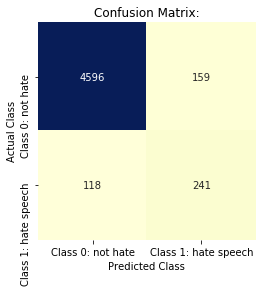

In [656]:
seaborn_confusion_matrix(y_val, nb_y_val_pred)

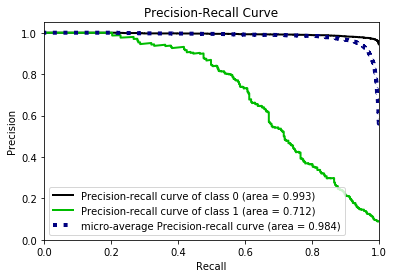

In [397]:
skplt.metrics.plot_precision_recall_curve(y_val, nb_y_val_prob)

Adjusted Accuracy: 0.956785295267892
Adjusted Precision: 0.7331081081081081
Adjusted Recall: 0.6044568245125348
Adjusted F1 Score: 0.6625954198473283




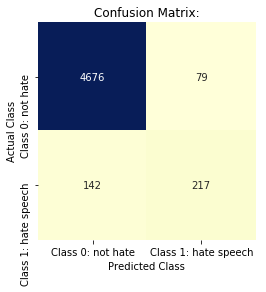

In [657]:
nb_adj_y_val, cm = adjust_threshold_and_score(y_val, nb_y_val_prob, .2)

## Final Naive Bayes Model:  Performance on Test Set 

In [424]:
#use smote and count vectorizer based on validation process
nb_test_model, nb_X_val, nb_y_train_pred, nb_y_val_pred, \
                nb_y_val_prob, nb_metrics_dict, nb_pred_df = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, 
                y_val, MultinomialNB(), count_vect, sampling= 'smote')

Adjusted Accuracy: 0.956785295267892
Adjusted Precision: 0.7331081081081081
Adjusted Recall: 0.6044568245125348
Adjusted F1 Score: 0.6625954198473283




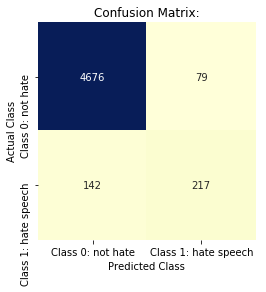

In [658]:
#final score based on adjusted threshold
nb_adj_y_true, cm = adjust_threshold_and_score(y_val, nb_y_val_prob, .2)

# Logistic Regression

### Comparing multiple vectorization methods and sampling methods

In [41]:
#Logistic Regression: lemmatizing + no adjustments
lr_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(solver = 'lbfgs', random_state = 10), 
                                            vectorization_list)

lr_results1

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.95,0.95,0.95,0.95,0.95,0.93
Train F1,0.52,0.52,0.52,0.47,0.47,0.10
Train Precision,0.85,0.85,0.85,0.88,0.88,1.00
Train Recall,0.37,0.37,0.37,0.32,0.32,0.05
Validation Accuracy,0.95,0.95,0.95,0.95,0.95,0.93
Validation F1,0.48,0.48,0.48,0.46,0.46,0.10
Validation Precision,0.81,0.81,0.81,0.86,0.86,1.00
Validation Recall,0.34,0.34,0.34,0.31,0.31,0.05


In [14]:
lr_results1.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

In [42]:
#Logistic Regression: compare vectorizers using lemmitizing + class balances
lr_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(class_weight= 'balanced', 
                            solver = 'lbfgs', random_state = 10), vectorization_list)
lr_results2

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.85,0.85,0.85,0.88,0.88,0.22
Train F1,0.48,0.48,0.48,0.51,0.51,0.15
Train Precision,0.32,0.32,0.32,0.36,0.36,0.08
Train Recall,0.95,0.95,0.95,0.88,0.88,1.00
Validation Accuracy,0.83,0.83,0.83,0.86,0.86,0.21
Validation F1,0.40,0.40,0.40,0.44,0.44,0.15
Validation Precision,0.27,0.27,0.27,0.31,0.31,0.08
Validation Recall,0.81,0.81,0.81,0.76,0.76,0.99


In [16]:
lr_results2.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

In [43]:
#Logistic Regression: compare vectorizers using lemmitizing + upsampling
lr_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(solver = 'lbfgs', 
                            random_state = 10), vectorization_list, sampling = 'upsample')
lr_results3

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.94,0.94,0.94,0.93,0.94,0.63
Train F1,0.94,0.94,0.94,0.93,0.94,0.43
Train Precision,0.94,0.94,0.94,0.92,0.93,0.96
Train Recall,0.94,0.94,0.94,0.94,0.95,0.28
Validation Accuracy,0.92,0.92,0.92,0.90,0.91,0.93
Validation F1,0.56,0.56,0.56,0.53,0.54,0.34
Validation Precision,0.45,0.45,0.45,0.41,0.41,0.56
Validation Recall,0.74,0.74,0.74,0.78,0.78,0.25


In [18]:
lr_results3.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

In [45]:
#Logistic Regression: compare vectorizers using lemmitizing + downsampling
lr_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(random_state = 10, solver = 'lbfgs'), 
                            vectorization_list, sampling = 'downsample')
lr_results4

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.95,0.95,0.95,0.94,0.94,0.64
Train F1,0.95,0.95,0.95,0.93,0.94,0.46
Train Precision,0.96,0.96,0.96,0.95,0.95,0.96
Train Recall,0.93,0.93,0.93,0.92,0.93,0.30
Validation Accuracy,0.87,0.87,0.87,0.86,0.86,0.94
Validation F1,0.47,0.47,0.47,0.46,0.46,0.36
Validation Precision,0.33,0.33,0.33,0.31,0.32,0.59
Validation Recall,0.81,0.81,0.81,0.83,0.84,0.26


In [20]:
lr_results4.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

In [44]:
#Logistic Regression: compare vectorizers using lemmitizing + smote
lr_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(random_state = 10, solver = 'lbfgs'), 
                            vectorization_list, sampling = 'smote', sample_class = 'not majority')
lr_results5

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.88,0.88,0.88,0.88,0.88,0.22
Train F1,0.46,0.46,0.46,0.50,0.50,0.15
Train Precision,0.34,0.34,0.34,0.35,0.35,0.08
Train Recall,0.73,0.73,0.73,0.88,0.88,1.00
Validation Accuracy,0.85,0.85,0.85,0.85,0.85,0.21
Validation F1,0.38,0.38,0.38,0.42,0.42,0.15
Validation Precision,0.27,0.27,0.27,0.29,0.29,0.08
Validation Recall,0.66,0.66,0.66,0.77,0.77,0.99


In [ ]:
lr_results5.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

### Grid Searching for Best Hyperparameters

In [46]:
np.random.seed(10)

logreg = LogisticRegression(random_state= 10)
c_space = np.linspace (.1, 10, 100)

parameters = {'C': c_space, 
          'penalty': ['l1', 'l2']}

scores = ['accuracy','recall','precision','f1']

lr_gs = GridSearchCV(logreg, param_grid = parameters, 
                           verbose = 0, scoring = scores, cv = 3, refit = 'f1')

In [47]:
lr_gs_model, lr_X_val, lr_y_train_pred, lr_y_val_pred, \
                lr_y_val_prob, lr_metrics_dict, lr_pred_df = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, 
                y_val, lr_gs, count_vect, sampling= 'upsample')

In [48]:
lr_gs_model.best_params_

{'C': 10.0, 'penalty': 'l1'}

In [52]:
lr_gs_model.best_score_

0.9428327390894242

In [83]:
lr_metrics_dict

{'Train Accuracy': 0.95,
 'Train Precision': 0.95,
 'Train Recall': 0.96,
 'Train F1': 0.95,
 'Validation Accuracy': 0.92,
 'Validation Precision': 0.47,
 'Validation Recall': 0.7,
 'Validation F1': 0.56}

In [54]:
lr_gs_df = pd.DataFrame(lr_gs_model.cv_results_)
lr_gs_df[lr_gs_df.rank_test_f1 == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
198,0.206947,0.033818,0.028084,0.006409,10,l1,"{'C': 10.0, 'penalty': 'l1'}",0.940457,0.944322,0.941167,...,0.926112,0.929195,0.002203,44,0.941149,0.945161,0.942188,0.942833,0.0017,1


In [59]:
lr_gs_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.159312,0.011445,0.029052,0.003543,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",0.866562,0.867981,0.868060,...,0.907598,0.909103,0.003635,200,0.858434,0.861561,0.861334,0.860443,0.001424,200
1,0.225658,0.019354,0.039356,0.005141,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.899369,0.903076,0.904180,...,0.915114,0.915093,0.001338,199,0.897229,0.901845,0.902901,0.900658,0.002463,198
2,0.136511,0.030292,0.037657,0.009533,0.2,l1,"{'C': 0.2, 'penalty': 'l1'}",0.898975,0.901420,0.901025,...,0.919485,0.921238,0.003449,195,0.895659,0.899404,0.898798,0.897954,0.001642,199
3,0.187624,0.015962,0.048992,0.020534,0.2,l2,"{'C': 0.2, 'penalty': 'l2'}",0.909306,0.912224,0.911593,...,0.917721,0.917287,0.002004,198,0.908191,0.911967,0.910940,0.910366,0.001594,196
4,0.203671,0.008518,0.051454,0.015007,0.3,l1,"{'C': 0.30000000000000004, 'penalty': 'l1'}",0.908123,0.909621,0.912145,...,0.922816,0.923910,0.002254,188,0.906041,0.908291,0.911022,0.908451,0.002037,197


In [62]:
lr_model, lr_X_val, lr_y_train_pred, lr_y_val_pred, \
                lr_y_val_prob, lr_metrics_dict, lr_pred_df = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, 
                y_val, LogisticRegression(C = 10.0, penalty = 'l1', random_state = 10),                                          
                 count_vect, sampling= 'upsample')

In [63]:
lr_metrics_dict

{'Train Accuracy': 0.95,
 'Train Precision': 0.95,
 'Train Recall': 0.96,
 'Train F1': 0.95,
 'Validation Accuracy': 0.92,
 'Validation Precision': 0.47,
 'Validation Recall': 0.7,
 'Validation F1': 0.56}

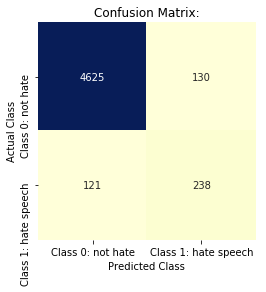

In [666]:
#want to reduce number of records predicted as 0 that are actually 1 
seaborn_confusion_matrix(y_val, lr_y_val_pred)

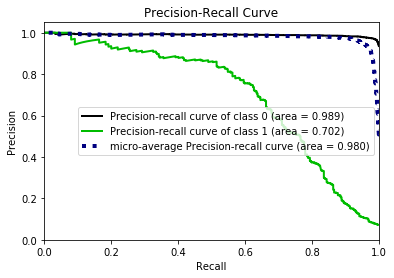

In [313]:
skplt.metrics.plot_precision_recall_curve(y_val, lr_y_val_prob)

Adjusted Accuracy: 0.9587407117716074
Adjusted Precision: 0.7466666666666667
Adjusted Recall: 0.6239554317548747
Adjusted F1 Score: 0.6798179059180577




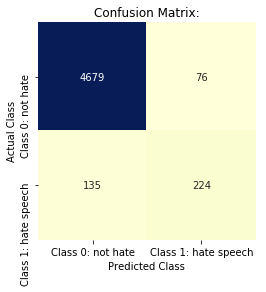

In [667]:
lr_pred_adj, cm = adjust_threshold_and_score(y_val, lr_y_val_prob, .2)

In [64]:
lr_pred_df['adjusted class'] = lr_pred_adj

In [59]:
lr_pred_df.head()

,prob 0,prob 1,predicted class,actual class,adjusted_class
17498,0.73,0.27,0,0,0
9203,1.00,0.00,0,0,0
17380,0.99,0.01,0,0,0
25176,1.00,0.00,0,0,0
3828,1.00,0.00,0,0,0


In [65]:
lr_misclassified_df = lr_pred_df[lr_pred_df['predicted class'] != lr_pred_df['actual class']]
lr_misclassified_df.head()

,prob 0,prob 1,predicted class,actual class,adjusted class
12608,0.94,0.06,0,1,0
23876,0.45,0.55,1,0,0
28669,0.75,0.25,0,1,0
14414,0.49,0.51,1,0,0
2748,0.72,0.28,0,1,0


In [69]:
lr_misclassified_df.shape

(210, 5)

In [70]:
lr_misclassified2_df = lr_misclassified_df[lr_misclassified_df['adjusted class'] != lr_misclassified_df['actual class']]
lr_misclassified2_df.head()

,prob 0,prob 1,predicted class,actual class,adjusted class
12608,0.94,0.06,0,1,0
28669,0.75,0.25,0,1,0
2748,0.72,0.28,0,1,0
8202,0.89,0.11,0,1,0
13596,0.61,0.39,0,1,0


In [71]:
lr_misclassified2_df.shape

(173, 5)

In [72]:
df.tweet[12608]

'a reson why so many muslims might be'

In [73]:
df.lem_tweet[28669]

'nazi swastika ebay trump donaldtrump republicwhitepower'

In [74]:
df.tweet[2748]

'ever notice how much scum #trump hires ?'

In [671]:
# import eli5
# from eli5 import explain_weights, explain_prediction
# from eli5.formatters import format_as_html, format_as_text, format_html_styles, fields

In [672]:
# eli5.show_weights(log, vec= count_vect, target_names= y_test, horizontal_layout=False)

In [673]:
# skplt.metrics.plot_precision_recall_curve(y_test, lr_y_prob_test)

## SVM


In [125]:
#SVM with lemmatizing + no class balance corrections
svm_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            SVC(gamma='auto', probability = True, random_state = 10), 
                            vectorization_list)
svm_results1 

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.93,0.93,0.93,0.93,0.93,0.93
Train F1,0.00,0.00,0.00,0.00,0.00,0.00
Train Precision,0.00,0.00,0.00,0.00,0.00,0.00
Train Recall,0.00,0.00,0.00,0.00,0.00,0.00
Validation Accuracy,0.93,0.93,0.93,0.93,0.93,0.93
Validation F1,0.00,0.00,0.00,0.00,0.00,0.00
Validation Precision,0.00,0.00,0.00,0.00,0.00,0.00
Validation Recall,0.00,0.00,0.00,0.00,0.00,0.00


In [126]:
# svm_results1.to_csv('data/SVM_results.csv',mode = 'a',header ='column_names')

In [127]:
#SVM with lemmatizing + class balance corrections
svm_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            SVC(gamma='auto', class_weight = 'balanced', probability = True, random_state = 10), 
                            vectorization_list)
svm_results2

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.90,0.90,0.90,0.53,0.17,0.93
Train F1,0.47,0.47,0.47,0.22,0.15,0.10
Train Precision,0.37,0.37,0.37,0.13,0.08,0.70
Train Recall,0.65,0.65,0.65,0.97,1.00,0.05
Validation Accuracy,0.90,0.90,0.90,0.52,0.17,0.93
Validation F1,0.47,0.47,0.47,0.22,0.15,0.09
Validation Precision,0.36,0.36,0.36,0.13,0.08,0.69
Validation Recall,0.64,0.64,0.64,0.99,1.00,0.05


In [ ]:
# svm_results2.to_csv('data/SVM_results.csv', mode = 'a',header ='column_names')

In [246]:
# Note: won't successfully complete training; may be a memory issue
svm_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            SVC(gamma='auto', random_state = 10), 
                            vectorization_list, sampling = 'upsample')
svm_results3 

AttributeError: predict_proba is not available when  probability=False

In [128]:
# SVM with lemmatizing + downsampling
svm_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            SVC(gamma= 'auto', probability = True, random_state = 10), 
                            vectorization_list, sampling = 'downsample')
svm_results4 

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.51,0.51,0.51,0.86,0.90,0.54
Train F1,0.67,0.67,0.67,0.87,0.89,0.15
Train Precision,0.50,0.50,0.50,0.81,0.91,1.00
Train Recall,1.00,1.00,1.00,0.94,0.88,0.08
Validation Accuracy,0.08,0.08,0.08,0.71,0.85,0.93
Validation F1,0.13,0.13,0.13,0.31,0.44,0.14
Validation Precision,0.07,0.07,0.07,0.18,0.30,1.00
Validation Recall,1.00,1.00,1.00,0.91,0.83,0.07


In [681]:
# Note: won't successfully complete training; may be a memory issue

#svm_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
#                             y_train, X_val.lem_tweet, y_val, 
#                             SVC(gamma='auto', probability = True, random_state = 10), 
#                             vectorization_list, sampling = 'smote')
# svm_results5 

#### Grid Searching:

In [ ]:
svc = SVC (random_state= 10)

params = {
'C': [0.1,.2, .5, 0.8, 1, 1.5, 2.0, 3.0, 4.0, 5.0],
'kernel':['linear', 'rbf'],
'gamma' :[0.1,0.8,1,1.2,1.4],
'class_weight': [{0:5, 1:5}, {0:2, 1:8}, {0:4, 1:6}, {0:8, 1:2}]}

scores = ['accuracy','recall','precision','f1']

scv_rs = RandomizedSearchCV(rfc, param_distributions = parameters, scoring = scores, cv = 3, refit = 'f1')

# Random Forest

### Comparing Classifier Performance with Multiple Vectorizer Methods and Class Imbalance Corrections

In [64]:
#Random Forest: compare vectorizers with lemmatizing; no explicit class balance corrections
rfc_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10), vectorization_list)
rfc_results1

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.99,0.99,0.99,0.99,0.99,0.93
Train F1,0.90,0.90,0.90,0.89,0.89,0.10
Train Precision,0.96,0.96,0.96,0.98,0.97,1.00
Train Recall,0.85,0.85,0.85,0.81,0.81,0.05
Validation Accuracy,0.93,0.93,0.93,0.95,0.95,0.93
Validation F1,0.52,0.52,0.52,0.54,0.55,0.10
Validation Precision,0.53,0.53,0.53,0.70,0.72,1.00
Validation Recall,0.50,0.50,0.50,0.44,0.44,0.05


In [118]:
# rfc_results1.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')


In [65]:
#Random Forest: compare vectorizers with lemmatizing and class weights balanced
rfc_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10, class_weight = 'balanced'), 
                            vectorization_list)
rfc_results2

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.96,0.96,0.96,0.96,0.95,0.22
Train F1,0.75,0.75,0.75,0.74,0.74,0.15
Train Precision,0.62,0.62,0.62,0.62,0.62,0.08
Train Recall,0.94,0.94,0.94,0.92,0.92,0.99
Validation Accuracy,0.88,0.88,0.88,0.91,0.90,0.22
Validation F1,0.44,0.44,0.44,0.46,0.45,0.15
Validation Precision,0.33,0.33,0.33,0.39,0.38,0.08
Validation Recall,0.66,0.66,0.66,0.56,0.55,0.99


In [120]:
# rfc_results2.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')

In [66]:
#Random Forest: compare vectorizers with lemmatizing and upsampling
rfc_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10), 
                            vectorization_list, sampling = 'upsample')
rfc_results3

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.99,0.99,0.99,0.99,0.99,0.63
Train F1,0.99,0.99,0.99,0.99,0.99,0.43
Train Precision,0.99,0.99,0.99,0.99,0.99,0.96
Train Recall,0.99,0.99,0.99,0.98,0.98,0.28
Validation Accuracy,0.93,0.93,0.93,0.95,0.95,0.93
Validation F1,0.52,0.52,0.52,0.63,0.63,0.34
Validation Precision,0.47,0.47,0.47,0.66,0.65,0.57
Validation Recall,0.58,0.58,0.58,0.61,0.61,0.25


In [122]:
# rfc_results3.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')

In [67]:
#Random Forest: compare vectorizers with lemmatizing and downsampling
rfc_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10), 
                            vectorization_list, sampling = 'downsample')
rfc_results4

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.98,0.98,0.98,0.98,0.99,0.64
Train F1,0.98,0.98,0.98,0.98,0.99,0.46
Train Precision,0.99,0.99,0.99,1.00,1.00,0.97
Train Recall,0.97,0.97,0.97,0.97,0.97,0.30
Validation Accuracy,0.86,0.86,0.86,0.87,0.87,0.94
Validation F1,0.44,0.44,0.44,0.46,0.46,0.36
Validation Precision,0.30,0.30,0.30,0.33,0.33,0.59
Validation Recall,0.77,0.77,0.77,0.78,0.76,0.26


In [124]:
# rfc_results4.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')

In [68]:
#Random Forest: compare vectorizers with lemmatizing and smote
rfc_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10), 
                            vectorization_list, sampling = 'smote', sample_class = 'not majority')
rfc_results5

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.95,0.95,0.95,0.96,0.96,0.22
Train F1,0.71,0.71,0.71,0.77,0.77,0.15
Train Precision,0.57,0.57,0.57,0.65,0.65,0.08
Train Recall,0.96,0.96,0.96,0.96,0.96,0.99
Validation Accuracy,0.85,0.85,0.85,0.89,0.89,0.22
Validation F1,0.38,0.38,0.38,0.45,0.46,0.15
Validation Precision,0.27,0.27,0.27,0.34,0.35,0.08
Validation Recall,0.64,0.64,0.64,0.65,0.67,0.99


In [126]:
# rfc_results5.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')

### Hypertuning Random Forest Hyperparameters: TFIDF Vectorizer and Upsampling

In [104]:
np.random.seed(0)
rfc = RandomForestClassifier(random_state=10)

parameters = {'n_estimators' : [40, 60, 80, 100, 120],
'max_leaf_nodes' : [100, 200, 300, 400],
'random_state' : [10],
'max_depth': [5, 6, 7, 8, 10, 20, 25, 30],
 'verbose' : [0]}
# 'class_weight': [{0:5, 1:5}, {0:2, 1:8}, {0:4, 1:6}, {0:6, 1: 4}, {0:8, 1:2}]}
#'class_weight': ['balanced', 'balanced_subsample']}

scores = ['accuracy','recall','precision','f1']

rfc_gs = GridSearchCV(rfc, param_grid = parameters, scoring = scores, cv = 3, refit = 'f1')

In [105]:
rfc_gs_model, rfc_X_val, rfc_y_train_pred, rfc_y_val_pred, \
                rfc_y_val_prob, rfc_metrics_dict, rfc_pred_df = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, 
                y_val, rfc_gs, tfidf_vect, sampling = 'upsample')

In [106]:
rfc_gs_model.best_params_

{'max_depth': 30,
 'max_leaf_nodes': 400,
 'n_estimators': 60,
 'random_state': 10,
 'verbose': 0}

In [107]:
rfc_df = pd.DataFrame(rfc_gs_model.cv_results_)
rfc_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_n_estimators,param_random_state,param_verbose,params,...,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.194871,0.014281,0.171810,0.015730,5,100,40,10,0,"{'max_depth': 5, 'max_leaf_nodes': 100, 'n_est...",...,0.902908,0.899933,0.002932,157,0.697913,0.708071,0.704751,0.703578,0.004229,141
1,0.273495,0.019657,0.242687,0.010871,5,100,60,10,0,"{'max_depth': 5, 'max_leaf_nodes': 100, 'n_est...",...,0.905459,0.901116,0.003505,153,0.701474,0.720581,0.703761,0.708605,0.008520,109
2,0.351683,0.013181,0.292270,0.006750,5,100,80,10,0,"{'max_depth': 5, 'max_leaf_nodes': 100, 'n_est...",...,0.906307,0.904219,0.001559,133,0.687500,0.703843,0.681626,0.690990,0.009400,157
3,0.436793,0.006970,0.355633,0.003014,5,100,100,10,0,"{'max_depth': 5, 'max_leaf_nodes': 100, 'n_est...",...,0.907902,0.905395,0.001773,129,0.694199,0.696032,0.682936,0.691056,0.005790,153
4,0.595508,0.063351,0.553707,0.093635,5,100,120,10,0,"{'max_depth': 5, 'max_leaf_nodes': 100, 'n_est...",...,0.911111,0.907422,0.002647,117,0.686588,0.698062,0.690695,0.691782,0.004747,149


In [108]:
rfc_df[rfc_df.rank_test_f1==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_n_estimators,param_random_state,param_verbose,params,...,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
156,0.793681,0.007564,0.520442,0.003081,30,400,60,10,0,"{'max_depth': 30, 'max_leaf_nodes': 400, 'n_es...",...,0.939361,0.934765,0.003835,1,0.781379,0.790276,0.796584,0.789413,0.006237,1


In [109]:
rfc_gs_model.best_score_

0.7894129581178615

In [110]:
rfc_metrics_dict

{'Train Accuracy': 0.83,
 'Train Precision': 0.96,
 'Train Recall': 0.69,
 'Train F1': 0.8,
 'Validation Accuracy': 0.93,
 'Validation Precision': 0.52,
 'Validation Recall': 0.61,
 'Validation F1': 0.56}

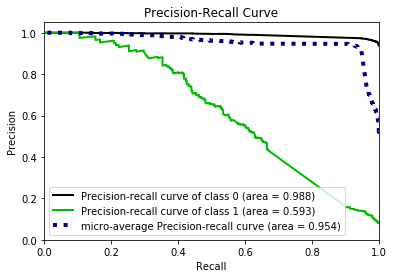

In [111]:
skplt.metrics.plot_precision_recall_curve(y_val, rfc_y_val_prob)

Adjusted Accuracy: 0.9333202972233086
Adjusted Precision: 0.5238095238095238
Adjusted Recall: 0.5515320334261838
Adjusted F1 Score: 0.537313432835821




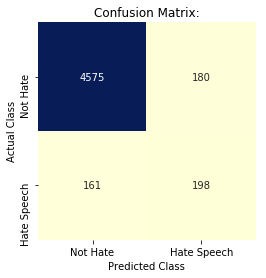

In [95]:
rfc_y_val_adj, cm = adjust_threshold_and_score(y_val, rfc_y_val_prob, .46)

###  Final Random Forest Model: Test Performance

In [ ]:
rfc = RandomForestClassifier(n_estimators = 60, max_leaf_nodes = 400, 
                       max_depth = 30, random_state = 10, verbose = 0)

In [ ]:
rfc_final_model, rfc_X_test, rfc_y_train2_pred, rfc_y_test2_pred, \
                rfc_y_test2_prob, rfc_metrics2_dict, rfc_pred2_df = \
wrapper_single_vectorization(X_model.lem_tweet, y_model, X_test.lem_tweet, 
                y_test, rfc, count_vect, sampling = 'upsample')

In [ ]:
rfc_metrics_dict

In [ ]:
rfc_adj_y_test, cm = adjust_threshold_and_score(y_test, rfc_y_test_prob, .46)

# AdaBoost

### Comparison Across Multiple Vectorization and Class Imbalance Correction Methods

In [129]:
#AdaBoost with Decision Tree, lemmatizing + no class balance corrections
ab_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(random_state =10), vectorization_list)
ab_results1

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.94,0.94,0.94,0.95,0.95,0.93
Train F1,0.45,0.45,0.45,0.45,0.45,0.10
Train Precision,0.71,0.71,0.71,0.76,0.77,1.00
Train Recall,0.33,0.33,0.33,0.32,0.32,0.05
Validation Accuracy,0.94,0.94,0.94,0.94,0.95,0.93
Validation F1,0.47,0.47,0.47,0.46,0.46,0.09
Validation Precision,0.71,0.71,0.71,0.74,0.76,1.00
Validation Recall,0.35,0.35,0.35,0.33,0.33,0.04


In [130]:
#AdaBoost with Decision Tree, lemmatizing + class balance corrections
dct = DecisionTreeClassifier(class_weight = 'balanced')
ab_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(base_estimator = dct, random_state = 10), vectorization_list)
ab_results2

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.96,0.96,0.96,0.95,0.96,0.22
Train F1,0.76,0.76,0.76,0.76,0.76,0.15
Train Precision,0.61,0.61,0.61,0.61,0.61,0.08
Train Recall,1.00,1.00,1.00,1.00,1.00,1.00
Validation Accuracy,0.88,0.88,0.88,0.89,0.89,0.21
Validation F1,0.42,0.42,0.42,0.45,0.44,0.15
Validation Precision,0.32,0.32,0.32,0.35,0.34,0.08
Validation Recall,0.62,0.62,0.62,0.64,0.62,0.99


In [131]:
#AdaBoost with Decision Tree, lemmatizing + upsampling
ab_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(random_state =10), vectorization_list, sampling = 'upsample')
ab_results3

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.75,0.75,0.75,0.75,0.75,0.60
Train F1,0.69,0.69,0.69,0.69,0.69,0.34
Train Precision,0.92,0.92,0.92,0.92,0.93,1.00
Train Recall,0.55,0.55,0.55,0.55,0.54,0.20
Validation Accuracy,0.93,0.93,0.93,0.93,0.93,0.94
Validation F1,0.52,0.52,0.52,0.52,0.54,0.30
Validation Precision,0.47,0.47,0.47,0.48,0.53,0.94
Validation Recall,0.57,0.57,0.57,0.57,0.54,0.18


In [132]:
#AdaBoost with Decision Tree, lemmatizing + downsampling
ab_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(random_state =10), vectorization_list, sampling = 'downsample')
ab_results4

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.73,0.73,0.73,0.75,0.75,0.60
Train F1,0.65,0.65,0.65,0.68,0.68,0.33
Train Precision,0.95,0.95,0.95,0.92,0.91,1.00
Train Recall,0.49,0.49,0.49,0.54,0.55,0.20
Validation Accuracy,0.93,0.93,0.93,0.91,0.92,0.94
Validation F1,0.49,0.49,0.49,0.46,0.49,0.31
Validation Precision,0.49,0.49,0.49,0.40,0.43,0.93
Validation Recall,0.48,0.48,0.48,0.54,0.57,0.18


In [133]:
#AdaBoost with Decision Tree, lemmatizing + smote
ab_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(random_state =10), vectorization_list, sampling = 'smote')
ab_results5

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.60,0.60,0.60,0.92,0.92,0.22
Train F1,0.24,0.24,0.24,0.46,0.46,0.15
Train Precision,0.14,0.14,0.14,0.42,0.42,0.08
Train Recall,0.87,0.87,0.87,0.51,0.51,1.00
Validation Accuracy,0.60,0.60,0.60,0.92,0.92,0.21
Validation F1,0.24,0.24,0.24,0.50,0.50,0.15
Validation Precision,0.14,0.14,0.14,0.46,0.45,0.08
Validation Recall,0.91,0.91,0.91,0.56,0.56,0.99


### Grid Searching for Best Hyperparameters using 

## XGBooster

In [134]:
xgb_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(random_state =10), vectorization_list)
xgb_results1

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.94,0.94,0.94,0.94,0.94,0.93
Train F1,0.34,0.34,0.34,0.35,0.35,0.10
Train Precision,0.90,0.90,0.90,0.94,0.94,1.00
Train Recall,0.21,0.21,0.21,0.21,0.21,0.05
Validation Accuracy,0.94,0.94,0.94,0.94,0.94,0.93
Validation F1,0.33,0.33,0.33,0.34,0.35,0.09
Validation Precision,0.86,0.86,0.86,0.87,0.89,1.00
Validation Recall,0.21,0.21,0.21,0.21,0.22,0.04


In [135]:
#XGB with scale and min child weight set to 1 to correct for class imbalance
xgb_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(scale_pos_weight = 1, min_child_weight = 1,
                            random_state =10), vectorization_list)
xgb_results2

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.94,0.94,0.94,0.94,0.94,0.93
Train F1,0.34,0.34,0.34,0.35,0.35,0.10
Train Precision,0.90,0.90,0.90,0.94,0.94,1.00
Train Recall,0.21,0.21,0.21,0.21,0.21,0.05
Validation Accuracy,0.94,0.94,0.94,0.94,0.94,0.93
Validation F1,0.33,0.33,0.33,0.34,0.35,0.09
Validation Precision,0.86,0.86,0.86,0.87,0.89,1.00
Validation Recall,0.21,0.21,0.21,0.21,0.22,0.04


In [136]:
xgb_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(random_state =10), vectorization_list, sampling = 'upsample')
xgb_results3

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.78,0.78,0.78,0.79,0.79,0.61
Train F1,0.74,0.74,0.74,0.74,0.74,0.36
Train Precision,0.92,0.92,0.92,0.94,0.94,1.00
Train Recall,0.61,0.61,0.61,0.61,0.61,0.22
Validation Accuracy,0.92,0.92,0.92,0.93,0.93,0.94
Validation F1,0.52,0.52,0.52,0.52,0.53,0.35
Validation Precision,0.46,0.46,0.46,0.50,0.51,0.94
Validation Recall,0.60,0.60,0.60,0.55,0.55,0.21


In [137]:
xgb_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(random_state =10), vectorization_list, sampling = 'downsample')
xgb_results4

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.76,0.76,0.76,0.77,0.77,0.58
Train F1,0.72,0.72,0.72,0.72,0.72,0.29
Train Precision,0.91,0.91,0.91,0.92,0.92,1.00
Train Recall,0.59,0.59,0.59,0.59,0.59,0.17
Validation Accuracy,0.92,0.92,0.92,0.91,0.92,0.94
Validation F1,0.50,0.50,0.50,0.47,0.50,0.27
Validation Precision,0.43,0.43,0.43,0.40,0.43,0.93
Validation Recall,0.61,0.61,0.61,0.59,0.60,0.16


In [138]:
xgb_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(random_state =10), vectorization_list, sampling = 'smote')
xgb_results5

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.93,0.93,0.93,0.92,0.94,0.21
Train F1,0.48,0.48,0.48,0.49,0.53,0.15
Train Precision,0.47,0.47,0.47,0.45,0.57,0.08
Train Recall,0.49,0.49,0.49,0.53,0.50,1.00
Validation Accuracy,0.93,0.93,0.93,0.92,0.94,0.20
Validation F1,0.50,0.50,0.50,0.49,0.52,0.15
Validation Precision,0.48,0.48,0.48,0.45,0.54,0.08
Validation Recall,0.52,0.52,0.52,0.54,0.50,0.99


# Word to Vec: Training Model and Testing Classifiers 

### X-train pre-processing

In [115]:
X_train_token_list = list(X_train.tokenized_tweet)

In [116]:
X_train_token_sumlist = sum(X_train_token_list,[])
X_train_unique_tokens = set(X_train_token_sumlist)
print('The unique number of words in the training dataset is: {}'.format(len(X_train_unique_tokens)))

The unique number of words in the training dataset is: 28682


#### X-val pre-processing

In [117]:
X_val_token_list = list(X_val['tokenized_tweet'])

In [118]:
X_val_token_sumlist = sum(X_val_token_list,[])
X_val_unique_tokens = set(X_val_token_sumlist)

print('The unique number of words in the validation dataset is: {}'.format(len(X_val_unique_tokens)))

The unique number of words in the validation dataset is: 11761


#### X-test pre-processing

In [119]:
X_test_token_list = list(X_test['tokenized_tweet'])
X_test_token_sumlist = sum(X_test_token_list,[])

X_test_unique_tokens = set(X_test_token_sumlist)
print('The unique number of words in the training dataset is: {}'.format(len(X_test_unique_tokens)))

The unique number of words in the training dataset is: 13677


### Training Word2Vec Model - 100D, 200D, 300D

In [197]:
from time import time
t = time()

w2v_model100 = gensim.models.Word2Vec(X_train_token_list, sg=1, min_count=1, size = 100)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.18 mins


In [199]:
w2v_model100.train(X_train_token_list, total_examples=w2v_model100.corpus_count, epochs=w2v_model100.epochs)

(1057102, 1267955)

In [200]:
w2v_model100.save('data/w2v100.model')
w2v_model100 = gensim.models.Word2Vec.load('data/w2v100.model')

In [202]:
#create average vector for train and test from model; return list of numpy arrays are then stacked 

X_train_w2v100 = np.concatenate([avg_word_vectors(sentence, w2v_model100, 100) for sentence in X_train_token_list])
X_val_w2v100 = np.concatenate([avg_word_vectors(sentence, w2v_model100, 100) for sentence in X_val_token_list])

with open('data/mean_w2v_vectors.pkl', 'wb') as f:
	pickle.dump([X_train_w2v100, X_val_w2v100], f)

In [ ]:
## W2V 200 dimension model:

In [203]:
w2v_model200 = gensim.models.Word2Vec(X_train_token_list, sg=1, min_count=1, size = 200)

In [204]:
w2v_model200.train(X_train_token_list, total_examples=w2v_model200.corpus_count, epochs=w2v_model200.epochs)

(1057216, 1267955)

In [205]:
w2v_model200.save('data/w2v_200d.model')
w2v_model200 = gensim.models.Word2Vec.load('data/w2v_200d.model')

In [206]:
#create average vector for train and test from model; return list of numpy arrays are then stacked
X_train_w2v200 = np.concatenate([avg_word_vectors(sentence, w2v_model200, 200) for sentence in X_train_token_list])
X_val_w2v200 = np.concatenate([avg_word_vectors(sentence, w2v_model200, 200) for sentence in X_val_token_list])

In [207]:
with open('data/mean_w2v_vectors200.pkl', 'wb') as f:
	pickle.dump([X_train_w2v200, X_val_w2v200], f)

In [ ]:
## W2V 300 dimension model:

In [208]:
w2v_model300 = gensim.models.Word2Vec(X_train_token_list, sg=1, min_count=1, size = 300)

In [209]:
w2v_model300.train(X_train_token_list, total_examples=w2v_model300.corpus_count, epochs=w2v_model300.epochs)

(1057537, 1267955)

In [210]:
w2v_model300.save('data/w2v_300d.model')
w2v_model300 = gensim.models.Word2Vec.load('data/w2v_300d.model')

In [211]:
#create average vector for train and test from model; return list of numpy arrays are then stacked 

X_train_w2v300 = np.concatenate([avg_word_vectors(sentence, w2v_model300, 300) for sentence in X_train_token_list])
X_val_w2v300 = np.concatenate([avg_word_vectors(sentence, w2v_model300, 300) for sentence in X_val_token_list])

with open('data/mean_w2v_vectors300.pkl', 'wb') as f:
	pickle.dump([X_train_w2v300, X_val_w2v300], f)

## Classification with Trained Word2Vec Embeddings - 100D

In [157]:
with open('data/mean_w2v_vectors.pkl', 'rb') as f:
    X_train_w2v100, X_val_w2v100 = pickle.load(f)

In [184]:
classifier_list = [('LogisticRegression', LogisticRegression(random_state = 10)),
                   ('SVM', SVC(gamma='auto', probability = True, random_state = 10)),
                    ('RandomForest', RandomForestClassifier(random_state = 10)),
                    ('AdaBoost', AdaBoostClassifier(random_state=10)),
                    ('XGBooster', XGBClassifier(random_state=10))]

In [162]:
w2v_model_results1 = mean_embedding_compare_classification(X_train_w2v100, y_train, X_val_w2v100, y_val, classifier_list)
w2v_model_results1

,LogisticRegression,SVM,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.94,0.93,0.99,0.94,0.95
Train F1,0.37,0.06,0.95,0.46,0.49
Train Precision,0.70,0.98,1.00,0.62,0.81
Train Recall,0.26,0.03,0.91,0.37,0.35
Validation Accuracy,0.94,0.93,0.95,0.93,0.94
Validation F1,0.38,0.05,0.48,0.46,0.45
Validation Precision,0.66,1.00,0.83,0.54,0.71
Validation Recall,0.26,0.03,0.33,0.40,0.33


In [175]:
w2v_model_results5 = mean_embedding_compare_classification(X_train_w2v100, y_train, X_val_w2v100, y_val, 
                                                           classifier_list, sampling = 'smote')
w2v_model_results5

,LogisticRegression,SVM,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.84,0.82,1.00,0.84,0.87
Train F1,0.43,0.40,0.99,0.41,0.49
Train Precision,0.29,0.26,0.98,0.28,0.34
Train Recall,0.84,0.87,1.00,0.80,0.87
Validation Accuracy,0.84,0.82,0.93,0.84,0.86
Validation F1,0.43,0.40,0.52,0.40,0.44
Validation Precision,0.28,0.26,0.50,0.27,0.31
Validation Recall,0.86,0.87,0.53,0.78,0.79


In [177]:
w2v_model_results4 = mean_embedding_compare_classification(X_train_w2v, y_train, X_val_w2v, y_val, classifier_list, 
                                      sampling = 'downsample')
w2v_model_results4

ValueError: feature_names mismatch: ['0 ', '1 ', '2 ', '3 ', '4 ', '5 ', '6 ', '7 ', '8 ', '9 ', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99']
expected 60, 45, 54, 48, 3 , 35, 36, 89, 71, 78, 93, 39, 64, 14, 85, 44, 26, 30, 61, 87, 94, 27, 11, 73, 7 , 17, 86, 9 , 31, 77, 62, 69, 16, 37, 13, 95, 5 , 58, 8 , 2 , 25, 4 , 79, 74, 52, 59, 90, 97, 99, 29, 68, 56, 80, 70, 40, 42, 67, 88, 34, 32, 10, 98, 28, 96, 66, 55, 15, 75, 24, 38, 43, 46, 53, 22, 41, 83, 19, 33, 21, 50, 63, 82, 0 , 65, 47, 6 , 91, 76, 1 , 20, 51, 81, 49, 12, 72, 18, 23, 57, 92, 84 in input data
training data did not have the following fields: f75, f27, f35, f90, f72, f59, f65, f50, f67, f37, f29, f58, f94, f87, f45, f9, f71, f33, f48, f3, f79, f60, f1, f98, f91, f83, f99, f80, f88, f17, f0, f7, f42, f81, f5, f49, f70, f21, f24, f84, f97, f4, f85, f8, f53, f38, f69, f43, f54, f44, f92, f57, f68, f63, f41, f96, f26, f46, f61, f18, f95, f66, f36, f82, f6, f12, f31, f2, f93, f20, f40, f10, f77, f56, f47, f55, f51, f13, f16, f52, f11, f19, f73, f74, f15, f78, f64, f30, f14, f76, f89, f86, f34, f39, f22, f32, f28, f23, f25, f62

### not working with XGBoost included

In [178]:
classifier_list = [('LogisticRegression', LogisticRegression(random_state = 10)),
                   ('SVM', SVC(gamma='auto', probability = True, random_state = 10)),
                    ('RandomForest', RandomForestClassifier(random_state = 10)),
                    ('AdaBoost', AdaBoostClassifier(random_state=10))]

In [180]:
w2v_model_results4 = mean_embedding_compare_classification(X_train_w2v100, y_train, X_val_w2v100, y_val, classifier_list, 
                                      sampling = 'downsample')
w2v_model_results4

,LogisticRegression,SVM,RandomForest,AdaBoost
Train Accuracy,0.58,0.51,0.98,0.75
Train F1,0.58,0.08,0.98,0.74
Train Precision,0.58,0.72,1.00,0.76
Train Recall,0.57,0.04,0.97,0.72
Validation Accuracy,0.51,0.89,0.37,0.39
Validation F1,0.15,0.04,0.13,0.13
Validation Precision,0.08,0.06,0.07,0.07
Validation Recall,0.61,0.03,0.67,0.64


In [181]:
w2v_model_results3 = mean_embedding_compare_classification(X_train_w2v100, y_train, X_val_w2v100, y_val, classifier_list, 
                                      sampling = 'upsample')
w2v_model_results3

,LogisticRegression,SVM,RandomForest,AdaBoost
Train Accuracy,0.56,0.55,0.98,0.64
Train F1,0.56,0.59,0.98,0.65
Train Precision,0.56,0.54,0.97,0.64
Train Recall,0.56,0.63,1.00,0.67
Validation Accuracy,0.54,0.45,0.91,0.59
Validation F1,0.11,0.12,0.10,0.11
Validation Precision,0.06,0.07,0.16,0.07
Validation Recall,0.41,0.53,0.07,0.37


## Classification with w2v Embeddings - 300D:

In [212]:
w2v300_model_results1 = mean_embedding_compare_classification(X_train_w2v300, y_train, 
                                                              X_val_w2v300, y_val, classifier_list)
w2v300_model_results1

,LogisticRegression,SVM,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.94,0.93,0.99,0.94,0.95
Train F1,0.37,0.00,0.95,0.45,0.50
Train Precision,0.71,0.00,1.00,0.61,0.80
Train Recall,0.25,0.00,0.90,0.36,0.37
Validation Accuracy,0.94,0.93,0.95,0.93,0.94
Validation F1,0.34,0.00,0.48,0.37,0.41
Validation Precision,0.65,0.00,0.86,0.54,0.72
Validation Recall,0.23,0.00,0.33,0.28,0.28


In [213]:
w2v300_model_results5 = mean_embedding_compare_classification(X_train_w2v300, y_train, X_val_w2v300, y_val, classifier_list, 
                                      sampling = 'smote')

w2v300_model_results5

,LogisticRegression,SVM,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.84,0.80,1.00,0.85,0.88
Train F1,0.43,0.38,0.99,0.43,0.50
Train Precision,0.29,0.24,0.99,0.29,0.35
Train Recall,0.85,0.87,1.00,0.82,0.88
Validation Accuracy,0.85,0.82,0.94,0.86,0.88
Validation F1,0.44,0.39,0.55,0.42,0.46
Validation Precision,0.30,0.26,0.56,0.29,0.33
Validation Recall,0.82,0.84,0.53,0.75,0.76


#  GLoVe: Transfer Learning with Pre-Trained Word Embeddings

## Preparing Mean Word Embeddings

In [ ]:
#Glove Twitter databse with 100 dimensions

In [215]:
glove_input_file = 'data/glove.twitter.27B.100d.txt'
glove_output_file = 'data/glove100.txt.word2vec'
glove2word2vec(glove_input_file, glove_output_file)

(1193514, 100)

In [216]:
glove100_model = KeyedVectors.load_word2vec_format('data/glove.txt.word2vec', binary=False)

In [217]:
X_train_glove100 = np.concatenate([avg_word_vectors(sentence, glove_model, 100) for sentence in X_train_token_list])
X_val_glove100 = np.concatenate([avg_word_vectors(sentence, glove_model, 100) for sentence in X_val_token_list])

In [218]:
with open('data/mean_glove_vectors100.pkl', 'wb') as f:
	pickle.dump([X_train_glove100, X_val_glove100], f)

In [ ]:
with open('data/mean_glove_vectors100.pkl', 'rb') as f:
    X_train_glove100, X_val_glove100 = pickle.load(f)

In [ ]:
#Glove Twitter databse with 200 dimensions

In [233]:
glove_input_file = 'data/glove.twitter.27B.200d.txt'
glove_output_file = 'data/glove200.txt.word2vec'
glove2word2vec(glove_input_file, glove_output_file)

(1193514, 200)

In [234]:
glove200_model = KeyedVectors.load_word2vec_format('data/glove200.txt.word2vec', binary=False)

In [244]:
X_train_glove200 = np.concatenate([avg_word_vectors(sentence, glove200_model, 200) for sentence in X_train_token_list])
X_val_glove200 = np.concatenate([avg_word_vectors(sentence, glove200_model, 200) for sentence in X_val_token_list])

In [245]:
with open('data/mean_glove_vectors200.pkl', 'wb') as f:
	pickle.dump([X_train_glove200, X_val_glove200], f)

## Classification with GLoVe 100 dimensions:

In [219]:
glove200_results1 = mean_embedding_compare_classification(X_train_glove200, y_train, X_val_glove200, 
                                                          y_val, classifier_list)
glove200_results1

,LogisticRegression,SVM,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.94,0.93,0.99,0.94,0.95
Train F1,0.44,0.04,0.94,0.48,0.52
Train Precision,0.68,0.94,1.00,0.64,0.81
Train Recall,0.33,0.02,0.89,0.38,0.38
Validation Accuracy,0.94,0.93,0.94,0.94,0.94
Validation F1,0.41,0.03,0.42,0.45,0.44
Validation Precision,0.65,1.00,0.79,0.57,0.72
Validation Recall,0.30,0.02,0.29,0.36,0.32


In [220]:
glove200_results5 = mean_embedding_compare_classification(X_train_glove200, y_train, X_val_glove200, 
                                                          y_val, classifier_list, sampling = 'smote')
glove200_results5

,LogisticRegression,SVM,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.86,0.86,1.00,0.86,0.89
Train F1,0.47,0.47,0.99,0.44,0.53
Train Precision,0.32,0.32,0.99,0.31,0.39
Train Recall,0.86,0.86,1.00,0.79,0.87
Validation Accuracy,0.86,0.86,0.94,0.85,0.88
Validation F1,0.45,0.46,0.56,0.41,0.48
Validation Precision,0.31,0.32,0.57,0.28,0.35
Validation Recall,0.82,0.83,0.56,0.75,0.79


In [224]:
mean_embedding_compare_classification2(X_train_glove100, y_train, X_val_glove100, y_val, classifier_list, 
                                      sampling = 'upsample')

KeyboardInterrupt: 

In [231]:
mean_embedding_compare_classification2(X_train_glove100, y_train, X_val_glove100, y_val, classifier_list, 
                                      sampling = 'downsample')

AttributeError: 'numpy.ndarray' object has no attribute 'values'

## Classification with GLoVe 200 dimensions:

In [ ]:
with open('data/mean_glove_vectors200.pkl', 'rb') as f:
    X_train_glove200, X_val_glove200 = pickle.load(f)

In [ ]:
glove100_results1 = mean_embedding_compare_classification(X_train_glove100, y_train, X_val_glove100, 
                                                          y_val, classifier_list)
glove100_results1

In [ ]:
glove100_results5 = mean_embedding_compare_classification(X_train_glove100, y_train, X_val_glove100, 
                                                          y_val, classifier_list, sampling = 'smote')
glove100_results5